# Классификация автомобилей по их фото¶


In [2]:
pip install --upgrade pip

     |████████████████████████████████| 1.5 MB 862 kB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.3.1
    Uninstalling pip-20.3.1:
      Successfully uninstalled pip-20.3.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-8kek5ukc
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29530 sha256=0e19a137dd4be769105f8d5a0121d50d2fffc2ee0b7d7f25e8d8d47d88570ea9
  Stored in directory: /tmp/pip-ephem-wheel-cache-sypy3efi/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
Note: you may need to restart the kernel to use updated packages.


### Импорт библиотек

In [4]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['sf-dl-car-classification']
Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.17.5
Tensorflow   : 2.3.1
Keras        : 2.4.0


### Основные настройки

In [6]:
EPOCHS               = 10  # количество эпох на обучение
BATCH_SIZE           = 4 # batch - требует уменьшения, если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4 # скорость обучения
VAL_SPLIT            = 0.15 # объем тестовых данных - 15%
CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (384, 512, IMG_CHANNELS)

In [7]:
DATA_PATH = '/kaggle/input/sf-dl-car-classification/'
PATH = "/kaggle/working/car/"

In [8]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

In [9]:
train_df = pd.read_csv(DATA_PATH+"train.csv")

In [10]:
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")

In [11]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile(DATA_PATH + data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['test_upload', 'train']


## Подготовка данных

### Аугментация данных

In [12]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=10, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(384, 512)
])



In [13]:
train_datagen = ImageDataAugmentor(augment = AUGMENTATIONS,
                                   validation_split=VAL_SPLIT)
        
test_datagen = ImageDataAugmentor()

### Генерация данных

Заворачиваем данные в генератор:

In [14]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с фото 
    target_size=(384, 512),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(384, 512),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    target_size=(384, 512),
    batch_size=BATCH_SIZE)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


Для сабмита мы используем другой источник test_datagen.flow_from_dataframe, так как нам нужно дать предсказание с привязкой к конкретному Id картинки из dataframe.

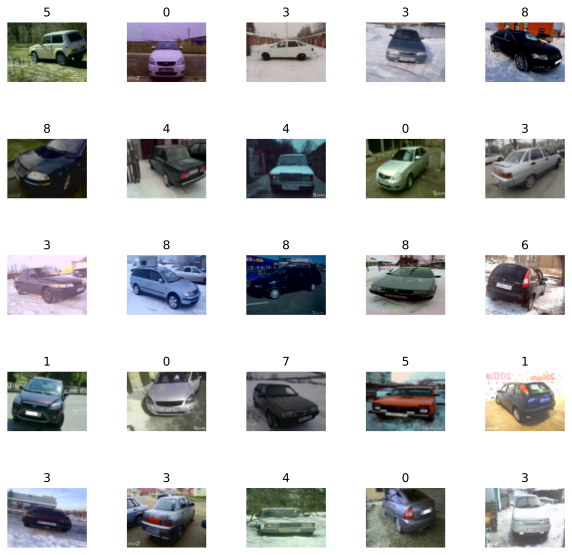

In [15]:
train_generator.show_data()

## Построение модели

### Загрузка предобученной сети EfficientNetB7

In [16]:
base_model = tf.keras.applications.EfficientNetB7(weights='imagenet', include_top=False, input_shape = input_shape)

258080768/258076736 [==============================] - 8s 0us/step


## Step_1

In [17]:
# Обучаем только верхние слои
base_model.trainable = False

### Установка новой "головы"

In [18]:
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D())
model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 12, 16, 2560)      64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               655616    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 64,756,897
Trainable params: 658,698
Non-trainable params: 64,098,199
______________________________________

In [20]:
LR = 0.001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(lr=LR), metrics=["accuracy"])

### Обучение модели

Добавим ModelCheckpoint. Эта функция позволяет сохранять прогресс обучения модели, чтобы в нужный момент можно было его подгрузить и дообучить модель.

In [21]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor = ['val_accuracy'], verbose = 1, mode = 'max')
#earlystop = EarlyStopping(monitor = ['val_accuracy'], patience = 5, restore_best_weights = True)
callbacks_list = [checkpoint]

Обучение:

In [22]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//train_generator.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/10
3308/3308 [==============================] - ETA: 0s - loss: 1.3708 - accuracy: 0.5290
Epoch 00001: saving model to best_model.hdf5
3308/3308 [==============================] - 518s 157ms/step - loss: 1.3708 - accuracy: 0.5290 - val_loss: 0.7117 - val_accuracy: 0.7539
Epoch 2/10
3308/3308 [==============================] - ETA: 0s - loss: 1.0257 - accuracy: 0.6464
Epoch 00002: saving model to best_model.hdf5
3308/3308 [==============================] - 514s 155ms/step - loss: 1.0257 - accuracy: 0.6464 - val_loss: 0.5682 - val_accuracy: 0.8106
Epoch 3/10
3308/3308 [==============================] - ETA: 0s - loss: 0.9367 - accuracy: 0.6777
Epoch 00003: saving model to best_model.hdf5
3308/3308 [==============================] - 511s 155ms/step - loss: 0.9367 - accuracy: 0.6777 - val_loss: 0.5498 - val_accuracy: 0.8166
Epoch 4/10
3308/3308 [==============================] - ETA: 0s - loss: 0.8619 - accuracy: 0.7106
Epoch 00004: saving model to best_model.hdf5
3308/3308 [======

In [23]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

583/583 [==============================] - 75s 129ms/step - loss: 0.4172 - accuracy: 0.8562
Accuracy: 85.62%


### Графики обучения

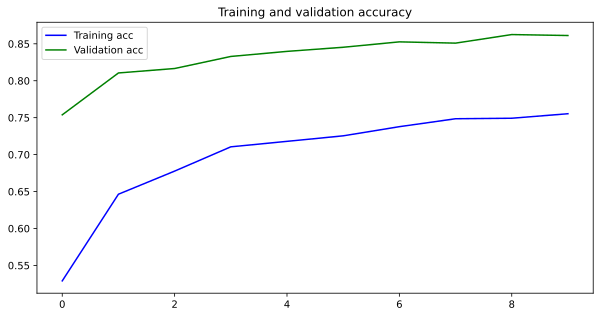

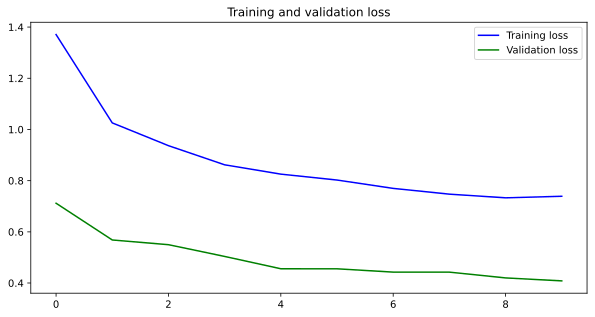

In [24]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

## Step_2

In [25]:
base_model.trainable = True

In [26]:
len(base_model.layers)

813

In [27]:
fine_tune_at = 400

In [28]:
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [29]:
LR = 0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(lr=LR), metrics=["accuracy"])

In [30]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//train_generator.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/10
3308/3308 [==============================] - ETA: 0s - loss: 0.8532 - accuracy: 0.7319
Epoch 00001: saving model to best_model.hdf5
3308/3308 [==============================] - 974s 294ms/step - loss: 0.8532 - accuracy: 0.7319 - val_loss: 0.2225 - val_accuracy: 0.9265
Epoch 2/10
3308/3308 [==============================] - ETA: 0s - loss: 0.4273 - accuracy: 0.8656
Epoch 00002: saving model to best_model.hdf5
3308/3308 [==============================] - 968s 293ms/step - loss: 0.4273 - accuracy: 0.8656 - val_loss: 0.1654 - val_accuracy: 0.9475
Epoch 3/10
3308/3308 [==============================] - ETA: 0s - loss: 0.3041 - accuracy: 0.9042
Epoch 00003: saving model to best_model.hdf5
3308/3308 [==============================] - 966s 292ms/step - loss: 0.3041 - accuracy: 0.9042 - val_loss: 0.1599 - val_accuracy: 0.9583
Epoch 4/10
3308/3308 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.9293
Epoch 00004: saving model to best_model.hdf5
3308/3308 [======

In [31]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

583/583 [==============================] - 74s 127ms/step - loss: 0.1384 - accuracy: 0.9691
Accuracy: 96.91%


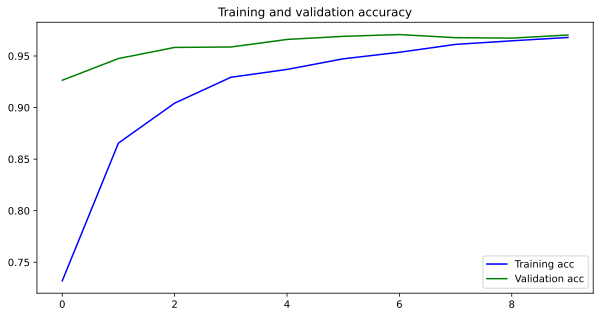

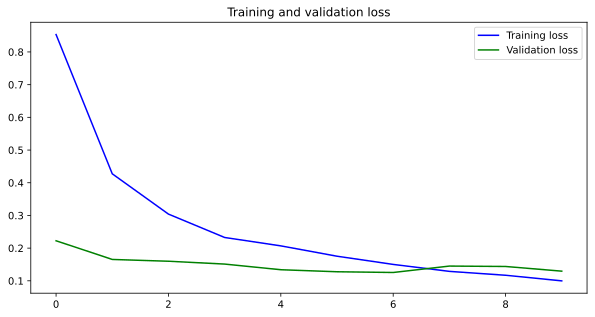

In [32]:
plot_history(history)

## Step_3

In [33]:
base_model.trainable = True

In [34]:
fine_tune_at = 100

In [35]:
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [36]:
LR = 0.00001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(lr=LR), metrics=["accuracy"])

In [37]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//train_generator.batch_size,
        epochs = 8,
        callbacks = callbacks_list
)

Epoch 1/8
3308/3308 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.9692
Epoch 00001: saving model to best_model.hdf5
3308/3308 [==============================] - 1667s 504ms/step - loss: 0.1011 - accuracy: 0.9692 - val_loss: 0.1431 - val_accuracy: 0.9699
Epoch 2/8
3308/3308 [==============================] - ETA: 0s - loss: 0.0940 - accuracy: 0.9704
Epoch 00002: saving model to best_model.hdf5
3308/3308 [==============================] - 1662s 503ms/step - loss: 0.0940 - accuracy: 0.9704 - val_loss: 0.1384 - val_accuracy: 0.9733
Epoch 3/8
3308/3308 [==============================] - ETA: 0s - loss: 0.0820 - accuracy: 0.9757
Epoch 00003: saving model to best_model.hdf5
3308/3308 [==============================] - 1664s 503ms/step - loss: 0.0820 - accuracy: 0.9757 - val_loss: 0.1274 - val_accuracy: 0.9725
Epoch 4/8
3308/3308 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9729
Epoch 00004: saving model to best_model.hdf5
3308/3308 [=======

In [38]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

583/583 [==============================] - 75s 129ms/step - loss: 0.1423 - accuracy: 0.9687
Accuracy: 96.87%


plot_history(history)

## Предсказание на тестовых данных

In [39]:
test_sub_generator.samples

6675

In [40]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

1669/1669 [==============================] - 201s 120ms/step


In [41]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [42]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,7


Результат на kaggle улучшился - 0.97213.